# Project Requirements

This notebook outlines the requirements and dependencies necessary for the analysis of the K-Drama dataset. Ensure all packages are installed before proceeding.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingno as msno  # Optional: for visualizing missing data

## 1. Data Import

Load the K-Drama dataset for subsequent analysis. This step ensures the data is available in a structured format for cleaning and exploration.

In [2]:
df = pd.read_csv('data/kdramas.csv')
df.head()

,title,rating,genres,votes,synopsis,age_rating,mainLead1,mainLead2,startYear,endYear,writer,director,id,runtimeMinutes,image_url
0,"Genie, Make a Wish",6.4,"Comedy,Fantasy,Romance",7.7K,"Jinn, a genie who awakens after a thousand yea...",TV-MA,Kim Woo-bin,Bae Suzy,2025,\N,['Kim Eun-sook'],['Lee Byeong-heon'],tt32409807,\N,https://m.media-amazon.com/images/M/MV5BOWM4Mj...
1,Squid Game,8.0,"Action,Drama,Mystery",723K,Hundreds of cash-strapped players accept a str...,TV-MA,Lee Jung-jae,Greg Chun,2021,2025,['Hwang Dong-hyuk'],['Hwang Dong-hyuk'],tt10919420,60,https://m.media-amazon.com/images/M/MV5BYTU3ZD...
2,When Life Gives You Tangerines,9.1,"Drama,History,Romance",29K,"In Jeju, a spirited girl and a steadfast boy's...",TV-14,IU,IU,2025,2025,"['Im Sang-choon', 'Lim Sang-Chung', 'Kim Won-s...",['Kim Won-seok'],tt26471411,60,https://m.media-amazon.com/images/M/MV5BZTBhZT...
3,Typhoon Family,8.1,Drama,296,"CEO Kang Tae Pung runs Typhoon Company, his fa...",NaN,Lee Jun-ho,Minha Kim,2025,\N,['\\N'],['Lee Na-jeong'],tt36856846,60,https://m.media-amazon.com/images/M/MV5BYzhkZT...
4,The Murky Stream,7.7,"Drama,History",649,Takryu tells the story of a man who was a gang...,TV-MA,Kim Ro-Woon,Shin Ye-eun,\N,\N,['Seong-il Cheon'],['Choo Chang-min'],tt31472425,\N,https://m.media-amazon.com/images/M/MV5BM2JhYT...


In [3]:
df.dtypes

title              object
rating            float64
genres             object
votes              object
synopsis           object
age_rating         object
mainLead1          object
mainLead2          object
startYear          object
endYear            object
writer             object
director           object
id                 object
runtimeMinutes     object
image_url          object
dtype: object

## 2. Data Cleaning & Preprocessing

Prepare the dataset for analysis by handling missing values, outliers, and scaling features. Proper preprocessing is essential for robust and reliable insights.

<Axes: >

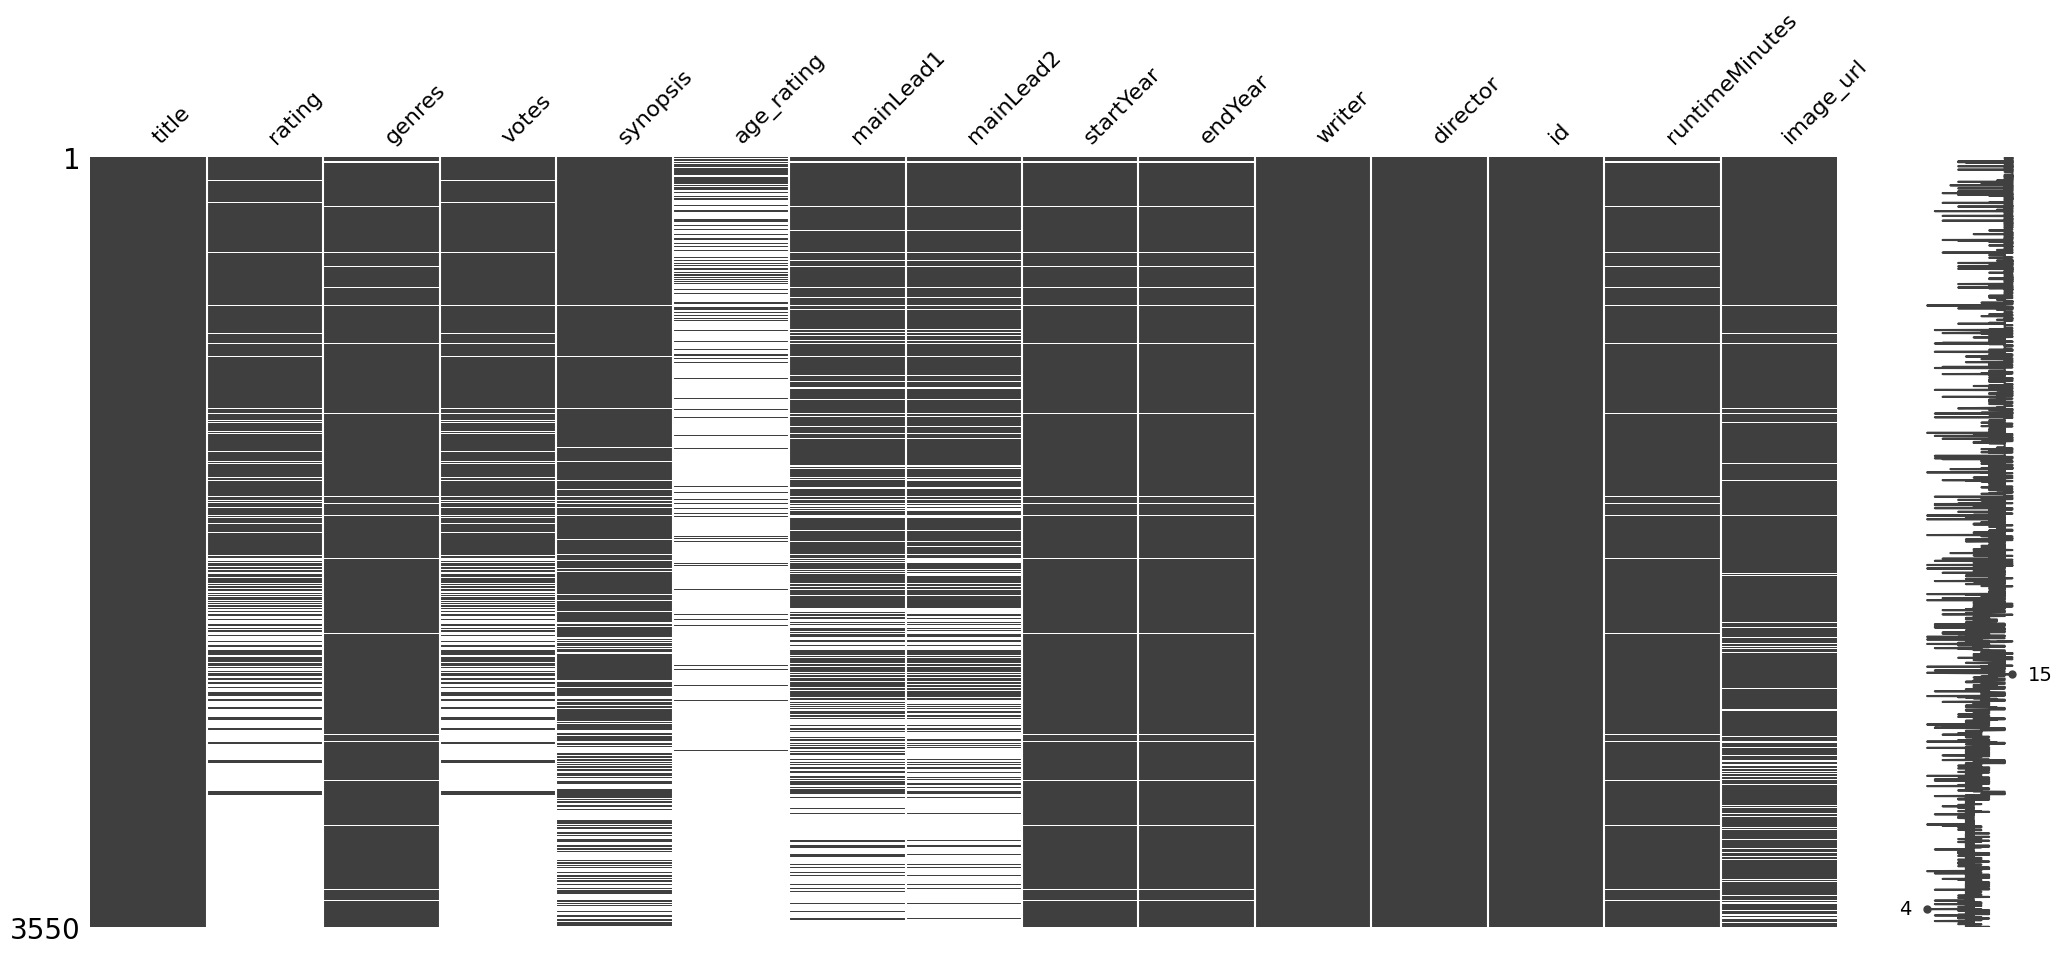

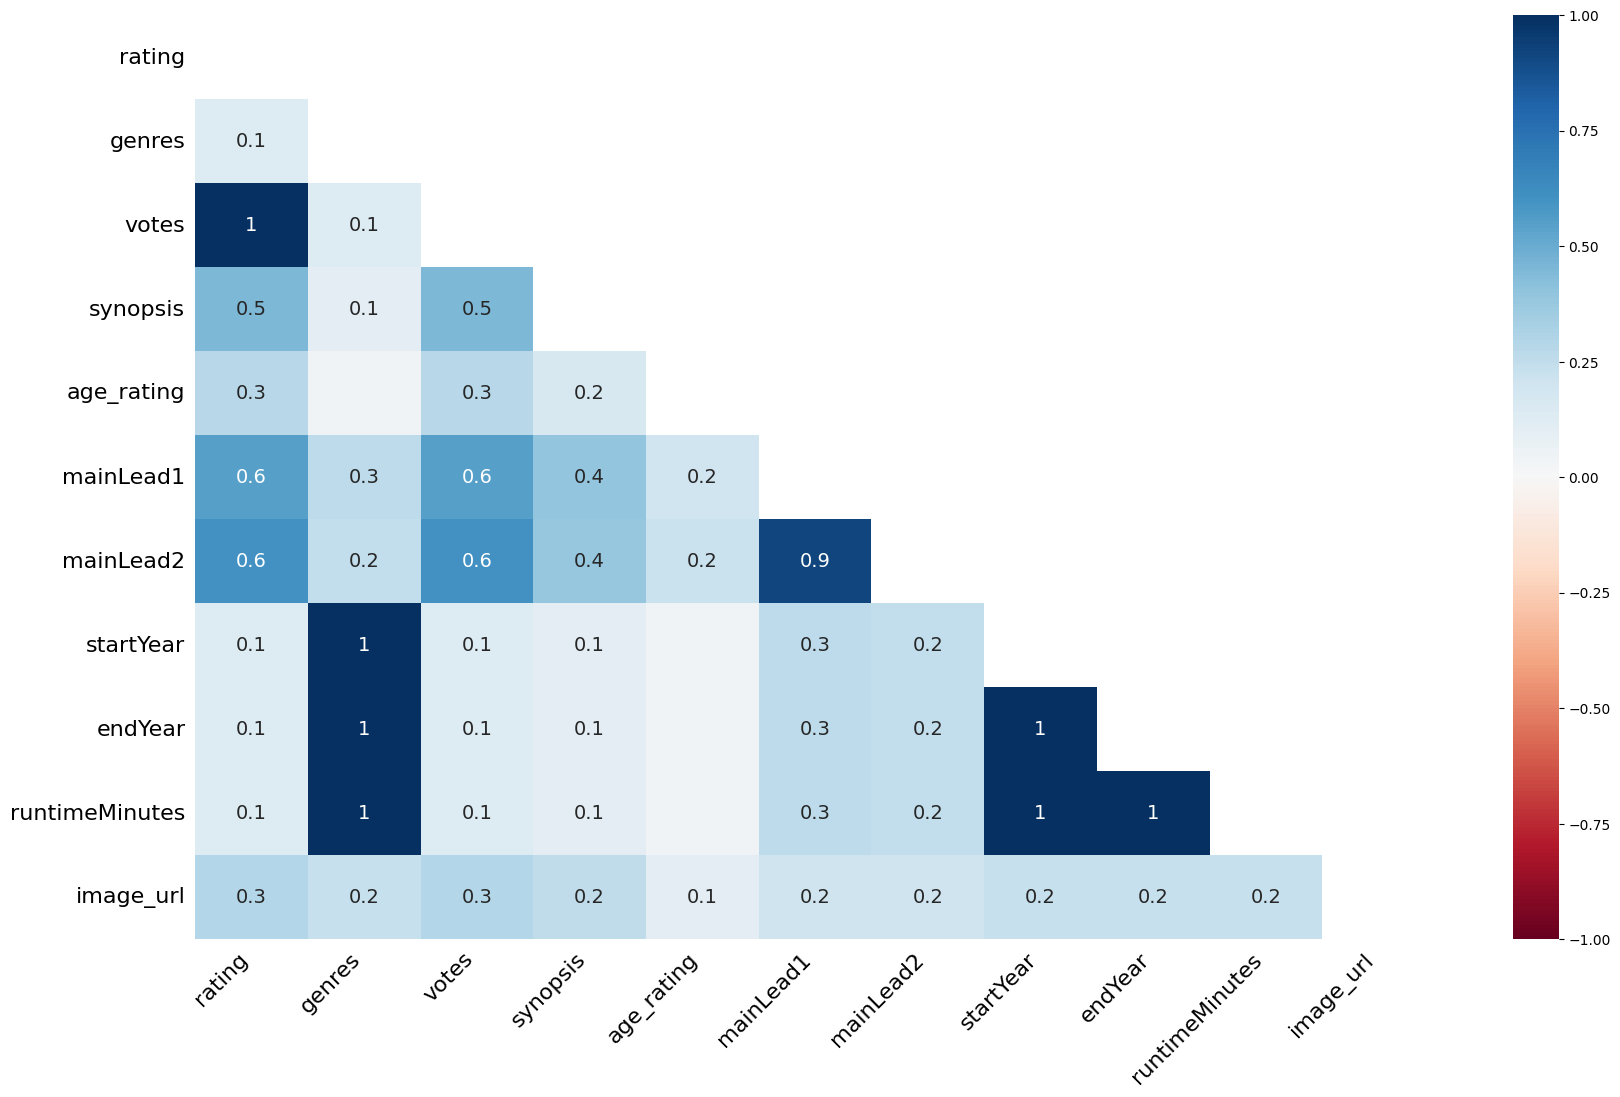

In [4]:
# Visualize missing data (optional)
msno.matrix(df)
msno.heatmap(df)

### Handling Missing Values

Identify and impute missing values to maintain data integrity and minimize bias in downstream analyses.

In [5]:
num_means = df.select_dtypes(include=['number']).mean()
df_filled = df.fillna(num_means)

### Outlier Detection and Treatment

Detect and address outliers to prevent them from skewing statistical analyses and visualizations.

In [6]:
# Handle outliers safely
from scipy import stats

# Compute z-scores on numeric columns only
numeric_df = df_filled.select_dtypes(include=['number'])
z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))

# Keep rows where all numeric columns have z-score < 3
mask = (z_scores < 3).all(axis=1)
df_no_outliers = df_filled.loc[mask]

# Cap outliers in 'votes' if the column exists and is numeric
if 'votes' in df_filled.columns and np.issubdtype(df_filled['votes'].dtype, np.number):
    upper_limit = df_filled['votes'].quantile(0.95)
    df_filled['votes'] = np.where(df_filled['votes'] > upper_limit, upper_limit, df_filled['votes'])


### Feature Scaling and Normalization

Standardize and normalize numeric features to ensure comparability and improve the performance of machine learning algorithms.

In [7]:
numeric_cols = df_filled.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
scaled_numeric = pd.DataFrame(
    scaler.fit_transform(df_filled[numeric_cols]),
    columns=numeric_cols,
    index=df_filled.index
)
df_scaled = df_filled.copy()
df_scaled[numeric_cols] = scaled_numeric

# Z-score Standardization (numeric columns only, then recombine)
scaler = StandardScaler()
standardized_numeric = pd.DataFrame(
    scaler.fit_transform(df_filled[numeric_cols]),
    columns=numeric_cols,
    index=df_filled.index
)
df_standardized = df_filled.copy()
df_standardized[numeric_cols] = standardized_numeric

### Encoding Categorical Variables

Convert categorical variables into a machine-readable format using one-hot encoding, enabling their use in modeling and analysis.

In [8]:
# One-hot encoding for categorical variables
# Use the correct column name and handle missing values
if 'genres' in df_scaled.columns:
    df_encoded = pd.get_dummies(
        df_scaled.assign(genres=df_scaled['genres'].fillna('Unknown')),
        columns=['genres']
    )
elif 'genre' in df_scaled.columns:
    df_encoded = pd.get_dummies(
        df_scaled.assign(genre=df_scaled['genre'].fillna('Unknown')),
        columns=['genre']
    )
else:
    df_encoded = df_scaled.copy()

### Save Cleaned Data

Export the cleaned and preprocessed dataset for reproducibility and future use.

In [9]:
df_encoded.to_csv('data/cleaned_preprocessed_data.csv', index=False)

print('Data cleaning and preprocessing complete. File saved as cleaned_preprocessed_data.csv')

Data cleaning and preprocessing complete. File saved as cleaned_preprocessed_data.csv


## 3. Exploratory Data Analysis (EDA)

Visualize and summarize the dataset to uncover patterns, trends, and potential anomalies. EDA provides foundational insights for deeper analysis.

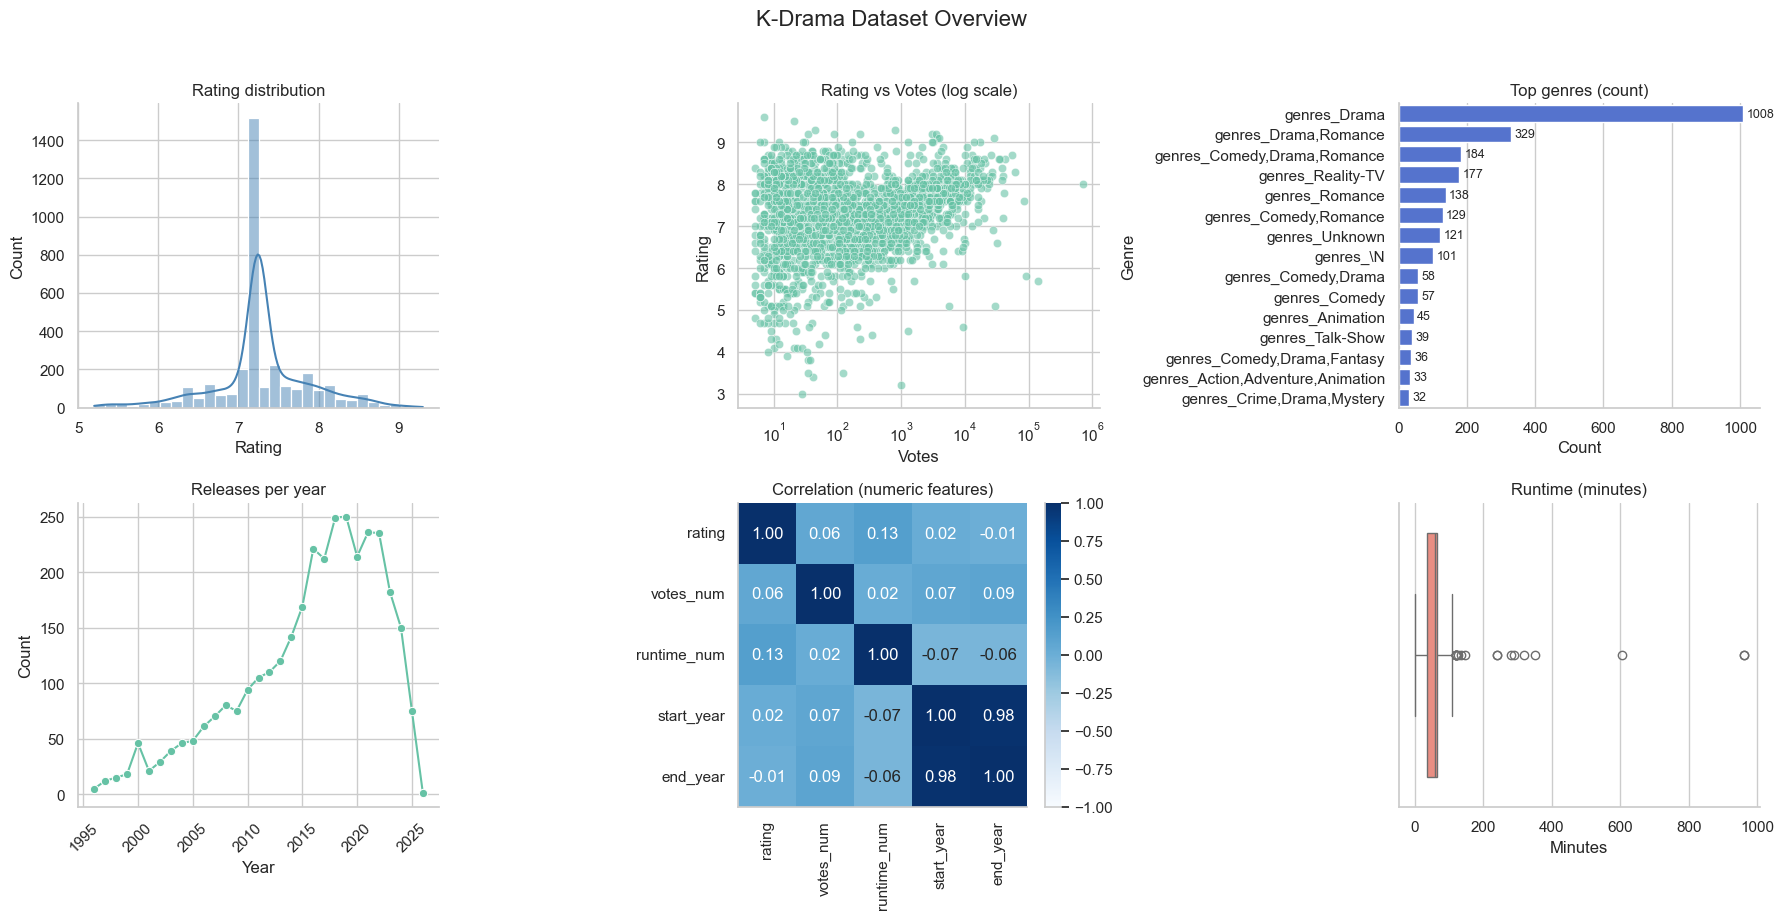

In [10]:
# Improved visuals
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='notebook', style='whitegrid', palette='Set2')

def parse_votes(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    if s == '' or s == '\\N':
        return np.nan
    mult = 1.0
    if s.endswith('K'):
        mult = 1_000.0
        s = s[:-1]
    elif s.endswith('M'):
        mult = 1_000_000.0
        s = s[:-1]
    try:
        return float(s.replace(',', '')) * mult
    except Exception:
        return np.nan

base = df_filled.copy()
if 'votes' in base.columns:
    base['votes_num'] = base['votes'].apply(parse_votes)
else:
    base['votes_num'] = np.nan
base['runtime_num'] = pd.to_numeric(base.get('runtimeMinutes', np.nan), errors='coerce')
base['start_year'] = pd.to_numeric(base.get('startYear', np.nan), errors='coerce')
base['end_year'] = pd.to_numeric(base.get('endYear', np.nan), errors='coerce')

genre_cols = [c for c in getattr(df_encoded, 'columns', []) if c.startswith('genres_')]
top_genres = pd.Series(dtype=int)
if genre_cols:
    genre_counts = df_encoded[genre_cols].sum().sort_values(ascending=False)
    top_genres = genre_counts.head(15)

year_counts = base['start_year'].dropna().astype(int).value_counts().sort_index()
plot_years = year_counts
if not year_counts.empty:
    recent_threshold = max(year_counts.index.max() - 30, year_counts.index.min())
    plot_years = year_counts[year_counts.index >= recent_threshold]

corr_cols = [c for c in ['rating', 'votes_num', 'runtime_num', 'start_year', 'end_year'] if c in base.columns]
corr = base[corr_cols].corr()

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle('K-Drama Dataset Overview', fontsize=16, y=1.02)

# 1) Rating distribution
ax = axes[0, 0]
if 'rating' in base.columns:
    sns.histplot(df_no_outliers['rating'].dropna() if 'rating' in df_no_outliers.columns else base['rating'].dropna(),
                 bins=30, kde=True, ax=ax, color='steelblue')
    ax.set_title('Rating distribution')
    ax.set_xlabel('Rating')
else:
    ax.text(0.5, 0.5, 'No rating column', ha='center', va='center')
    ax.axis('off')

# 2) Rating vs Votes (log-scaled votes)
ax = axes[0, 1]
scatter_df = base[['rating', 'votes_num']].dropna() if {'rating', 'votes_num'}.issubset(base.columns) else pd.DataFrame()
if not scatter_df.empty:
    sns.scatterplot(data=scatter_df, x='votes_num', y='rating', ax=ax, alpha=0.6)
    ax.set_xscale('log')
    ax.set_title('Rating vs Votes (log scale)')
    ax.set_xlabel('Votes')
    ax.set_ylabel('Rating')
else:
    ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
    ax.axis('off')

# 3) Top genres
ax = axes[0, 2]
if not top_genres.empty:
    sns.barplot(x=top_genres.values, y=top_genres.index, ax=ax, orient='h', color='royalblue')
    for i, v in enumerate(top_genres.values):
        ax.text(v + (top_genres.values.max() * 0.01), i, int(v), va='center', fontsize=9)
    ax.set_title('Top genres (count)')
    ax.set_xlabel('Count')
    ax.set_ylabel('Genre')
else:
    ax.text(0.5, 0.5, 'No genre columns', ha='center', va='center')
    ax.axis('off')

# 4) Releases per year (recent)
ax = axes[1, 0]
if not plot_years.empty:
    sns.lineplot(x=plot_years.index, y=plot_years.values, ax=ax, marker='o')
    ax.set_title('Releases per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'No year data', ha='center', va='center')
    ax.axis('off')

# 5) Correlation heatmap
ax = axes[1, 1]
if not corr.empty:
    sns.heatmap(corr, annot=True, cmap='Blues', ax=ax, vmin=-1, vmax=1, fmt='.2f')
    ax.set_title('Correlation (numeric features)')
else:
    ax.text(0.5, 0.5, 'No numeric correlation', ha='center', va='center')
    ax.axis('off')

# 6) Runtime distribution
ax = axes[1, 2]
if 'runtime_num' in base.columns and base['runtime_num'].notna().any():
    sns.boxplot(x=base['runtime_num'], ax=ax, color='salmon')
    ax.set_title('Runtime (minutes)')
    ax.set_xlabel('Minutes')
else:
    ax.text(0.5, 0.5, 'No runtime data', ha='center', va='center')
    ax.axis('off')

sns.despine()
plt.tight_layout()
plt.show()

# K-Drama Data Analysis: Visualizations & Insights

This section presents a comprehensive suite of visualizations and analyses to extract actionable insights from the K-Drama dataset. Each cell is designed to address a specific analytical question or hypothesis.

## 1. Distribution of Ratings

Examine the distribution of drama ratings to understand the overall quality perception and identify potential skewness or outliers in audience feedback.

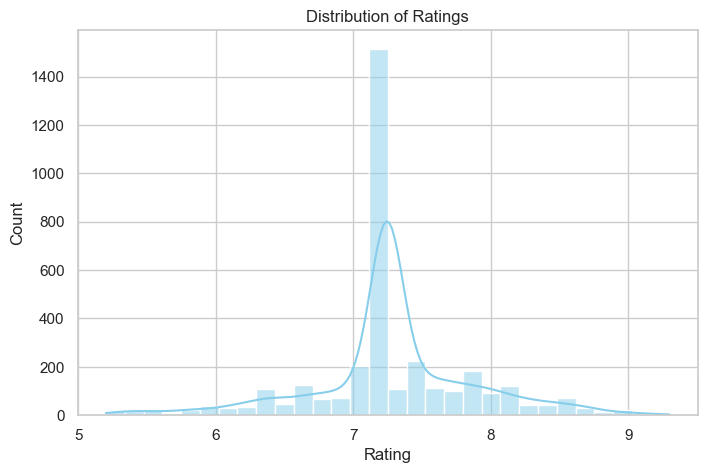

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df_no_outliers['rating'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## 2. Top Genres

Identify the most prevalent genres in the K-Drama landscape. This analysis highlights dominant themes and audience preferences.

/var/folders/23/9861x19n6cj07_1zkxf3814w0000gn/T/ipykernel_77581/1575334400.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10], palette='viridis')


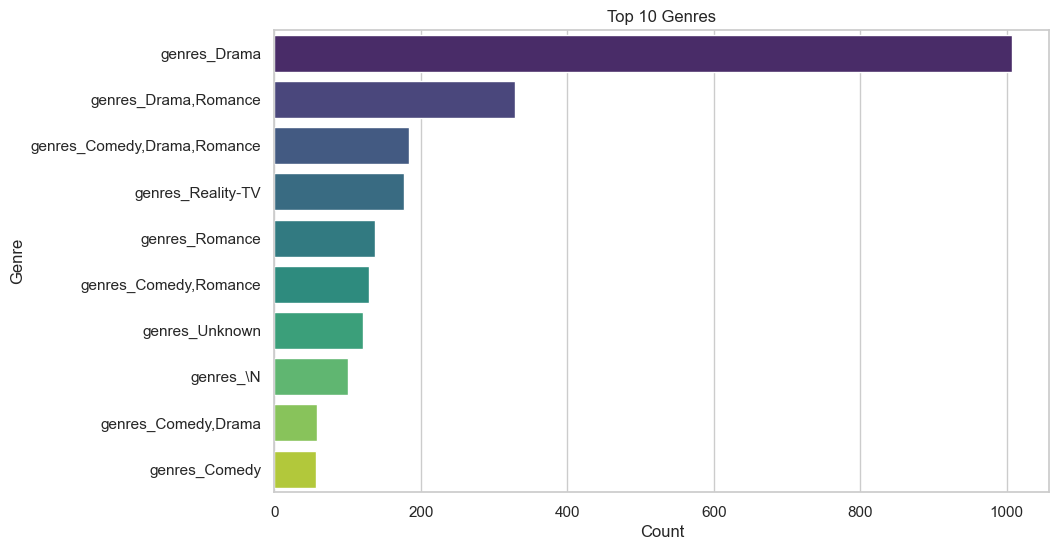

In [12]:
genre_cols = [col for col in df_encoded.columns if col.startswith('genres_')]
if genre_cols:
    genre_counts = df_encoded[genre_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10], palette='viridis')
    plt.title('Top 10 Genres')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()
else:
    print("No genre columns found.")

## 3. Annual Release Trends

Analyze the temporal distribution of K-Drama releases to detect industry growth, seasonal patterns, and historical shifts in production volume.

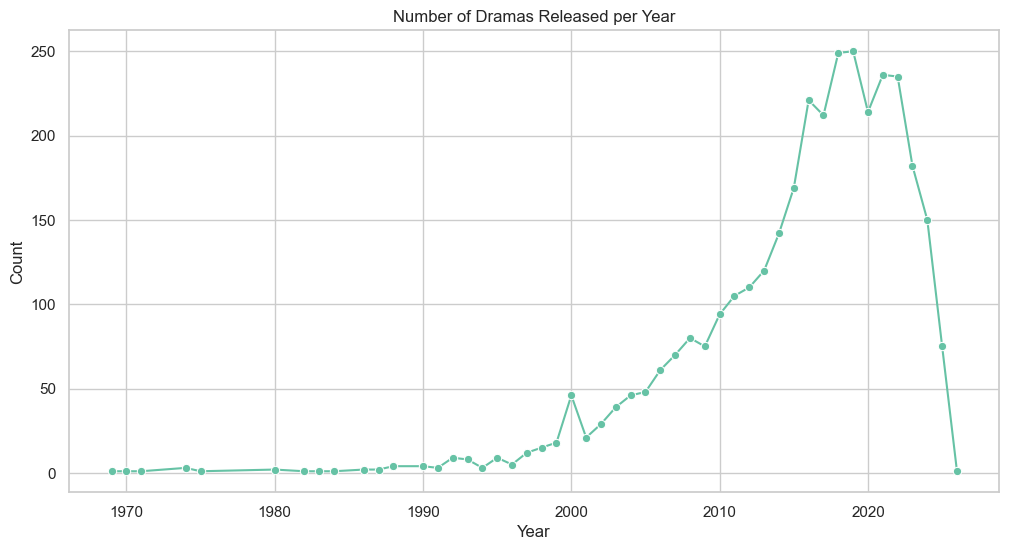

In [13]:
if 'startYear' in df.columns:
    year_counts = pd.to_numeric(df['startYear'], errors='coerce').dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
    plt.title('Number of Dramas Released per Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()
else:
    print("No startYear column found.")

## 4. Rating vs. Votes

Investigate the relationship between drama ratings and audience engagement (measured by votes). This scatter plot can reveal whether higher-rated dramas tend to attract more viewers.

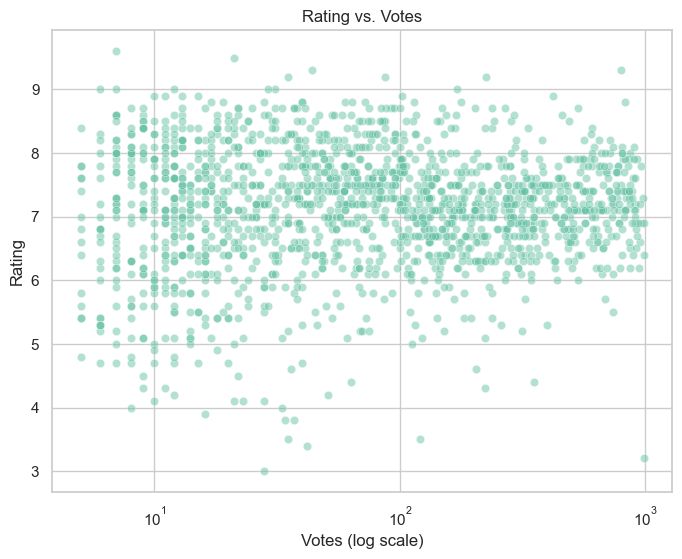

In [14]:
if {'rating', 'votes'}.issubset(df.columns):
    df['votes_num'] = pd.to_numeric(df['votes'], errors='coerce')
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='votes_num', y='rating', data=df, alpha=0.5)
    plt.xscale('log')
    plt.title('Rating vs. Votes')
    plt.xlabel('Votes (log scale)')
    plt.ylabel('Rating')
    plt.show()
else:
    print("Required columns not found.")

## 5. Correlation Heatmap

Visualize the pairwise correlations among numeric features to identify strong relationships and potential multicollinearity in the dataset.

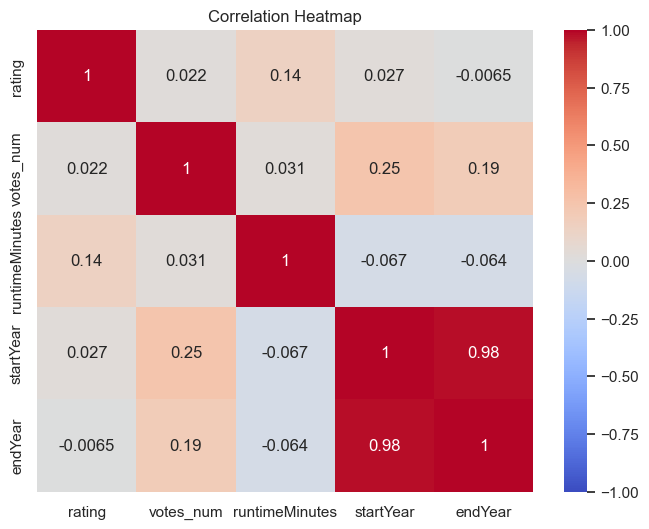

In [15]:
corr_cols = [c for c in ['rating', 'votes_num', 'runtimeMinutes', 'startYear', 'endYear'] if c in df.columns]
if corr_cols:
    corr = df[corr_cols].apply(pd.to_numeric, errors='coerce').corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("No numeric columns found for correlation.")

## 6. Runtime Distribution

Assess the distribution of episode runtimes to understand typical production lengths and spot any anomalies.

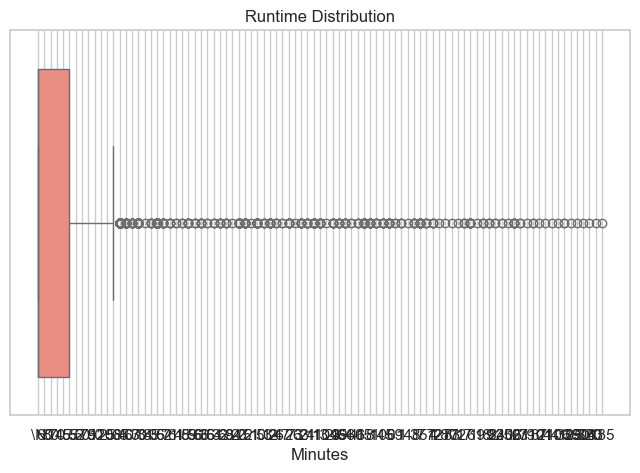

In [16]:
if 'runtimeMinutes' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df['runtimeMinutes'].dropna(), color='salmon')
    plt.title('Runtime Distribution')
    plt.xlabel('Minutes')
    plt.show()
else:
    print("No runtimeMinutes column found.")

### Optional: Workflow Automation

Define reusable functions to automate common data processing steps, enhancing reproducibility and efficiency.

## 7. Genre Trends Over Time

Track the evolution of the most popular genres across years to uncover shifts in audience interests and industry focus.

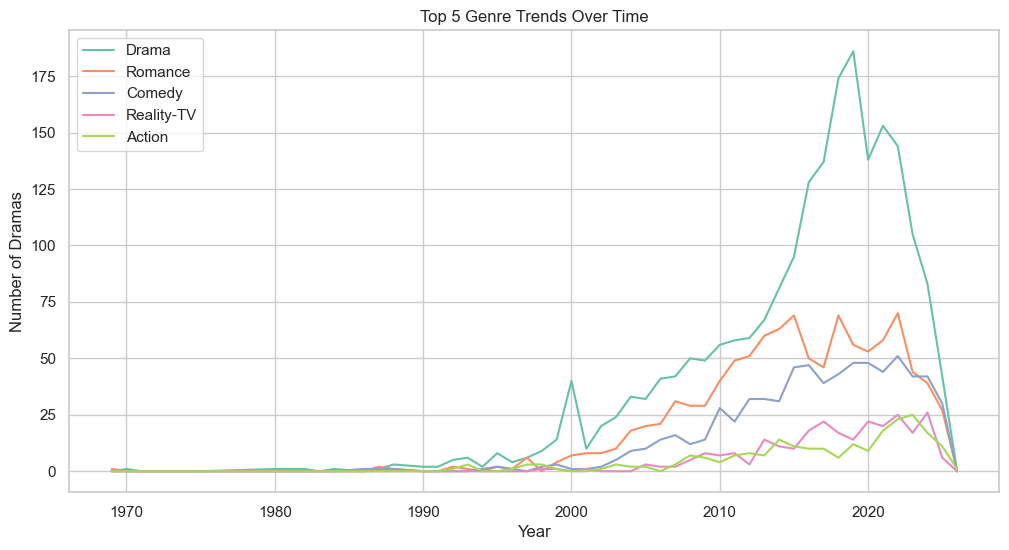

In [17]:
# Plot genre trends over time (top 5 genres)
if 'startYear' in df.columns and 'genres' in df.columns:
    df_genre_year = df[['startYear', 'genres']].dropna()
    df_genre_year['startYear'] = pd.to_numeric(df_genre_year['startYear'], errors='coerce')
    df_genre_year = df_genre_year.dropna(subset=['startYear'])
    df_genre_year['startYear'] = df_genre_year['startYear'].astype(int)
    genre_counts = df['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
    top_genres = genre_counts.head(5).index.tolist()
    genre_year = df_genre_year.copy()
    for genre in top_genres:
        genre_year[genre] = genre_year['genres'].str.contains(genre, na=False)
    genre_trends = genre_year.groupby('startYear')[top_genres].sum()
    plt.figure(figsize=(12,6))
    for genre in top_genres:
        plt.plot(genre_trends.index, genre_trends[genre], label=genre)
    plt.title('Top 5 Genre Trends Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Dramas')
    plt.legend()
    plt.show()
else:
    print("Required columns not found for genre trends.")

## 8. Missing Data Report
Visualize and summarize missing data patterns.

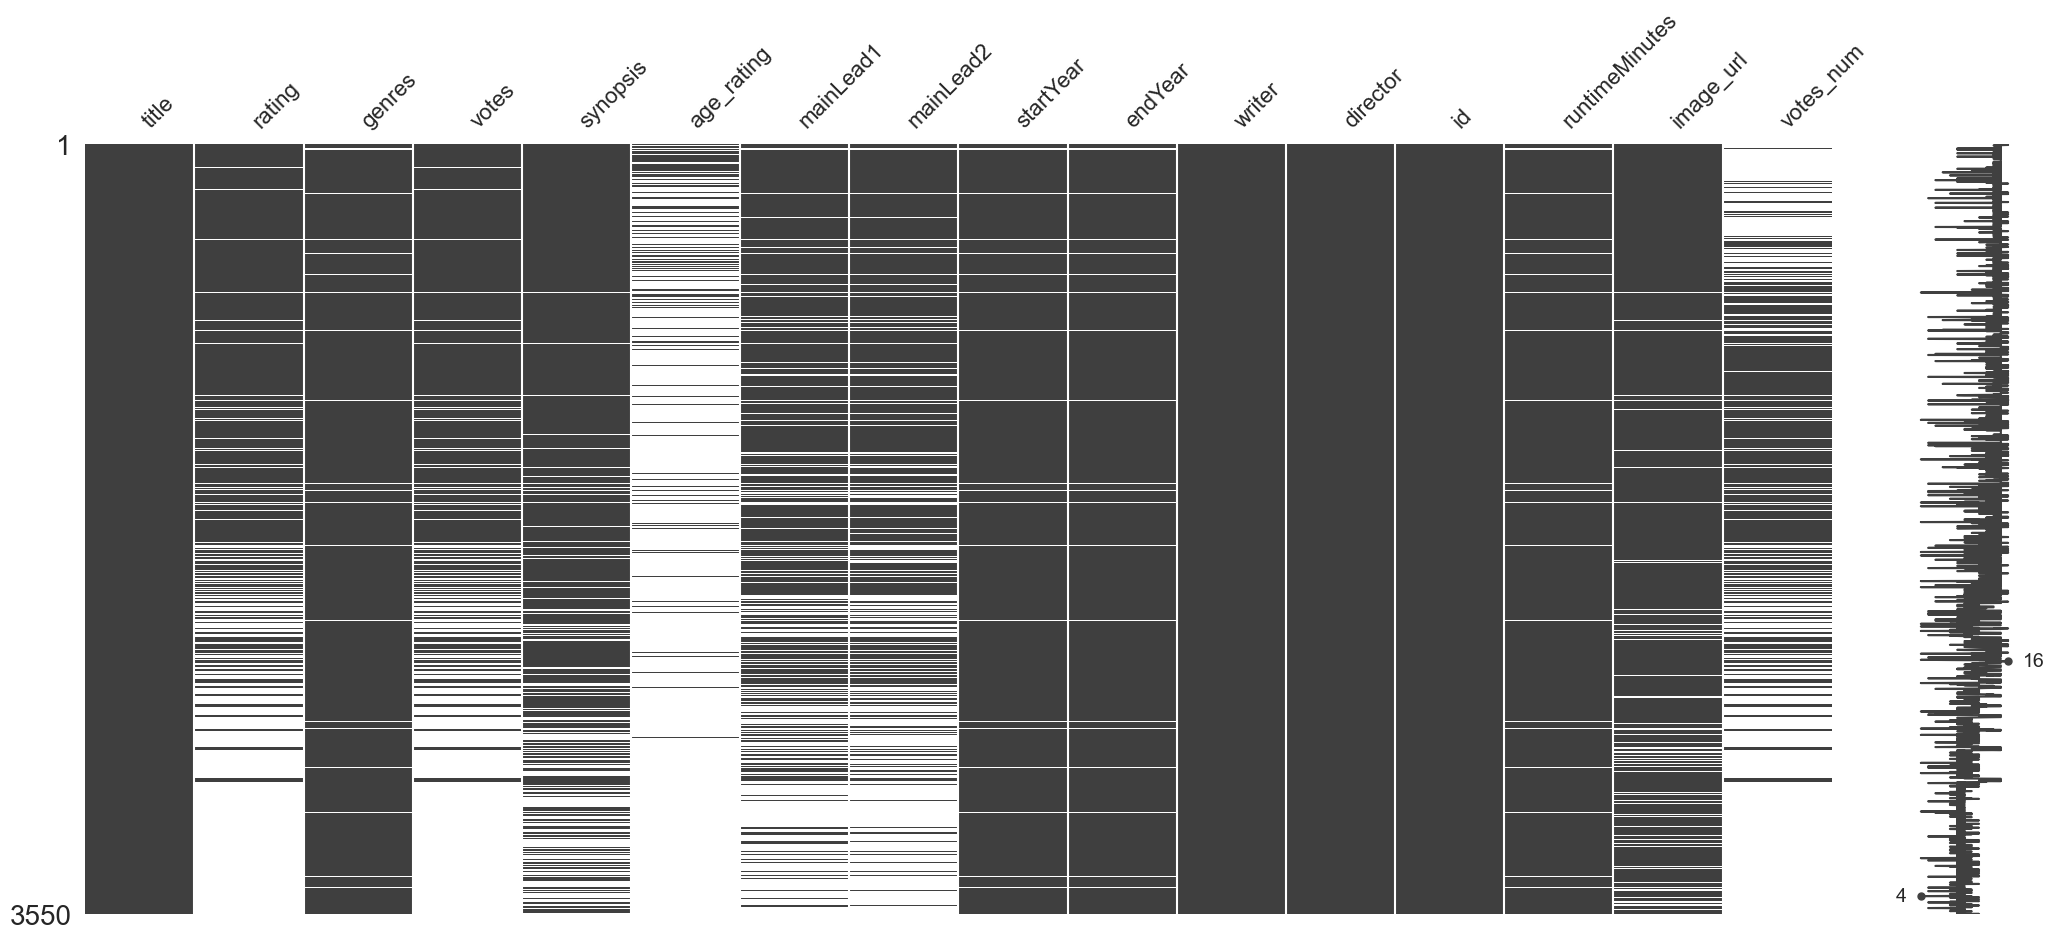

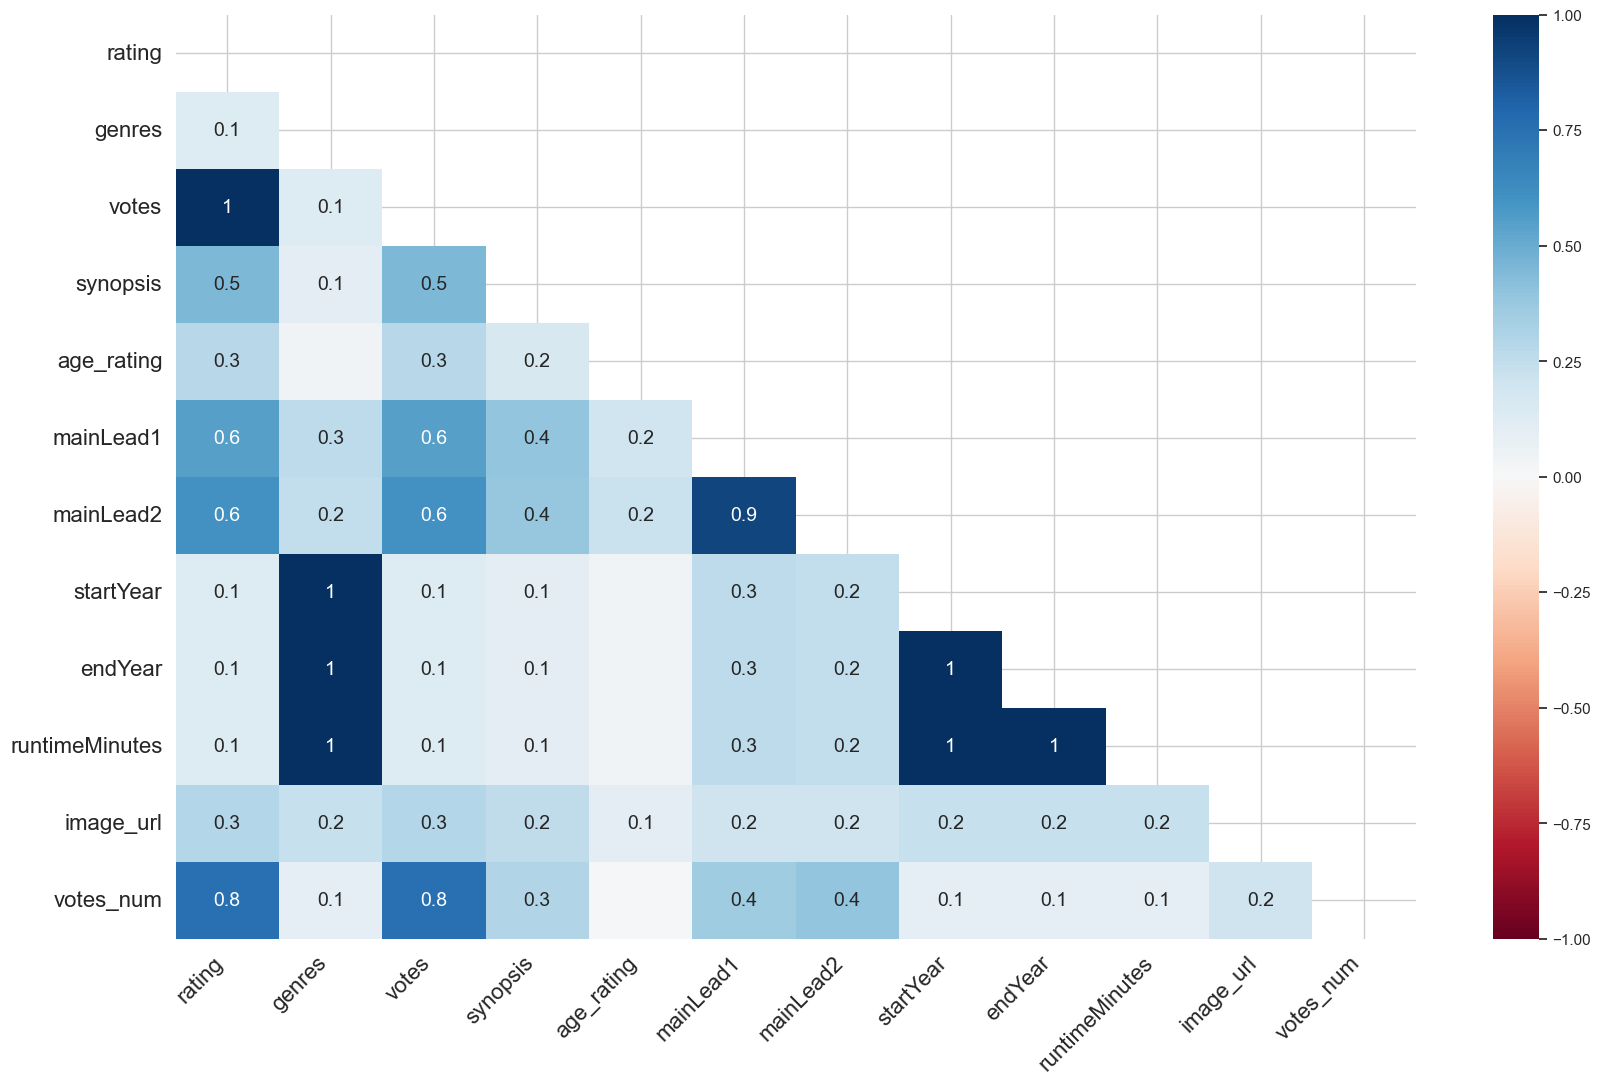

age_rating        3117
votes_num         1909
rating            1412
votes             1412
mainLead2         1332
mainLead1         1188
synopsis           680
image_url          269
genres             121
startYear          121
endYear            121
runtimeMinutes     121
title                0
writer               0
director             0
id                   0
dtype: int64

In [18]:
# Visualize missing data matrix and heatmap
import missingno as msno
msno.matrix(df)
plt.show()
msno.heatmap(df)
plt.show()

# Print missing data summary
display(df.isnull().sum().sort_values(ascending=False))

## 9. Word Cloud of Drama Titles

Generate a word cloud to highlight the most frequent terms in drama titles, offering insights into common themes and motifs.

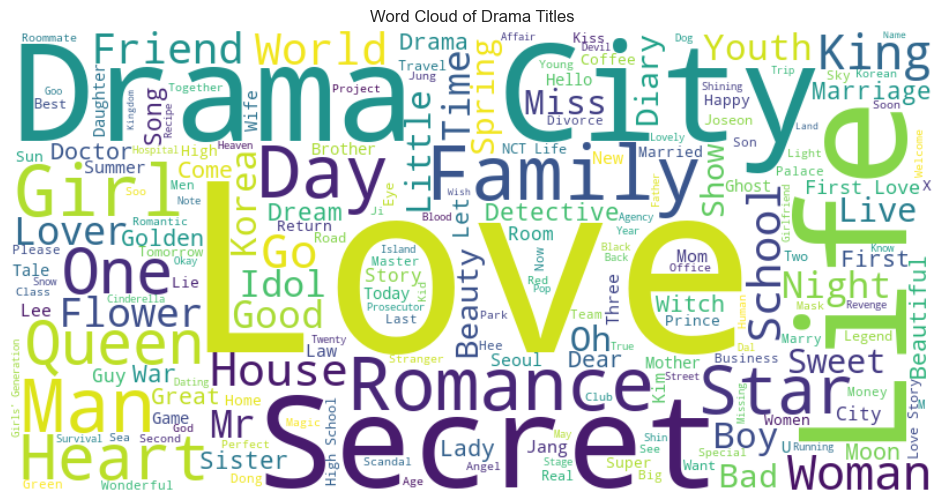

In [19]:
# Generate a word cloud of drama titles
from wordcloud import WordCloud, STOPWORDS

if 'title' in df.columns:
    text = ' '.join(df['title'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Drama Titles')
    plt.show()
else:
    print("No 'title' column found for word cloud.")

## 10. Yearly Release Analysis

Gain insights into the temporal distribution of K-Drama releases by visualizing the number of dramas produced each year. This analysis helps identify trends, peaks, and shifts in production volume over time, which can be valuable for understanding industry growth, historical context, and the impact of external factors on content creation.

/var/folders/23/9861x19n6cj07_1zkxf3814w0000gn/T/ipykernel_77581/1621509811.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index, y=year_counts.values, palette='Blues')


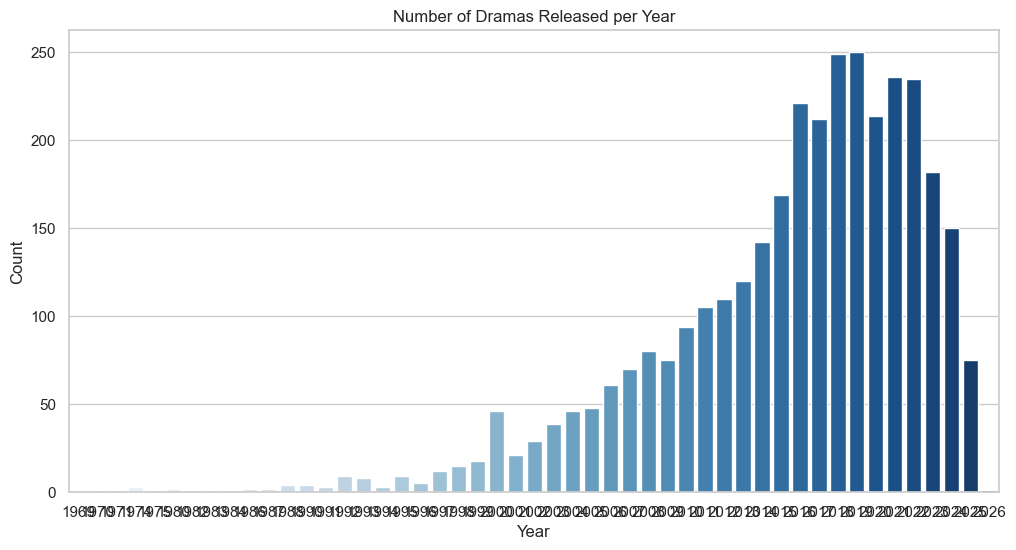

In [20]:
# Analyze releases by year (month not available in this dataset)
if 'startYear' in df.columns:
    year_counts = pd.to_numeric(df['startYear'], errors='coerce').dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(12,6))
    sns.barplot(x=year_counts.index, y=year_counts.values, palette='Blues')
    plt.title('Number of Dramas Released per Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()
else:
    print("No 'startYear' column found for year analysis.")

## 11. Clustering Dramas

Apply KMeans clustering to group dramas with similar numeric characteristics. This unsupervised learning approach can reveal natural groupings and support content recommendation or segmentation strategies.

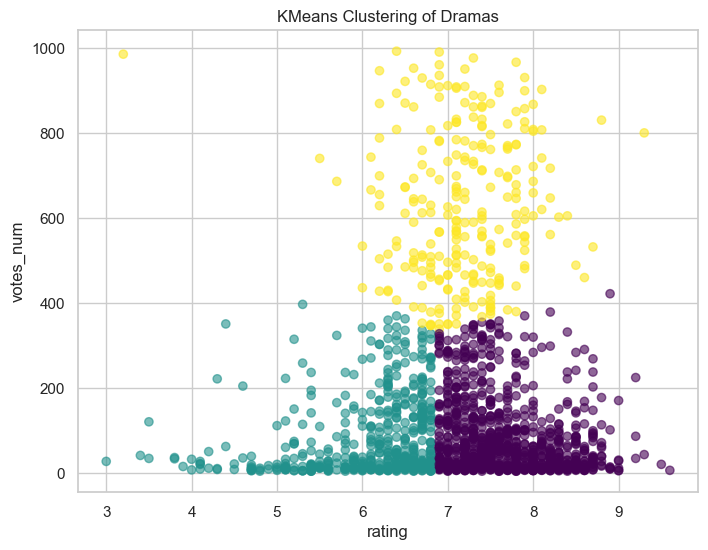

In [21]:
# KMeans clustering on numeric features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(numeric_cols) >= 2:
    X = df[numeric_cols].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    X['Cluster'] = clusters
    plt.figure(figsize=(8,6))
    plt.scatter(X[numeric_cols[0]], X[numeric_cols[1]], c=clusters, cmap='viridis', alpha=0.6)
    plt.xlabel(numeric_cols[0])
    plt.ylabel(numeric_cols[1])
    plt.title('KMeans Clustering of Dramas')
    plt.show()
else:
    print("Not enough numeric columns for clustering.")

### Optional: End-to-End Automation

Automate the entire data processing and analysis pipeline for streamlined, repeatable workflows.

In [ ]:
def load_data(filepath):
    return pd.read_csv(filepath)

def handle_missing_values(df):
    return df.fillna(df.mean())

def remove_outliers(df):
    z_scores = np.abs(stats.zscore(df))
    return df[(z_scores < 3).all(axis=1)]

def scale_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def encode_categorical(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns)

def save_data(df, output_filepath):
    df.to_csv(output_filepath, index=False)

# Example usage:
df = load_data('kdramas.csv')
df = handle_missing_values(df)
df = remove_outliers(df)
df = scale_data(df)
df = encode_categorical(df, ['categorical_column_name'])
save_data(df, 'cleaned_preprocessed_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'analysis.csv'